<a href="https://colab.research.google.com/github/ChristyAlex23160055/Praticum_Part2/blob/main/Encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cuda


<ipython-input-28-afbdb302f5c9>:75: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Malicious'] = data['Malicious'].replace({'benign': 0, 'malicious': 1})


Train set shape: (44548, 603)
Validation set shape: (5563, 603)
Test set shape: (5568, 603)
Epoch 1/100, Train Loss: 0.175757, Val Loss: 0.075745
Epoch 2/100, Train Loss: 0.056344, Val Loss: 0.048210
Epoch 3/100, Train Loss: 0.039438, Val Loss: 0.036546
Epoch 4/100, Train Loss: 0.034256, Val Loss: 0.033891
Epoch 5/100, Train Loss: 0.033716, Val Loss: 0.028785
Epoch 6/100, Train Loss: 0.031151, Val Loss: 0.033074
Epoch 7/100, Train Loss: 0.029966, Val Loss: 0.028992
Epoch 8/100, Train Loss: 0.029592, Val Loss: 0.028916
Epoch 9/100, Train Loss: 0.028869, Val Loss: 0.028546
Epoch 10/100, Train Loss: 0.028261, Val Loss: 0.029436
Epoch 11/100, Train Loss: 0.028604, Val Loss: 0.026966
Epoch 12/100, Train Loss: 0.027705, Val Loss: 0.032829
Epoch 13/100, Train Loss: 0.027723, Val Loss: 0.026772
Epoch 14/100, Train Loss: 0.027029, Val Loss: 0.026704
Epoch 15/100, Train Loss: 0.027024, Val Loss: 0.026226
Epoch 16/100, Train Loss: 0.026057, Val Loss: 0.025258
Epoch 17/100, Train Loss: 0.025321, V

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


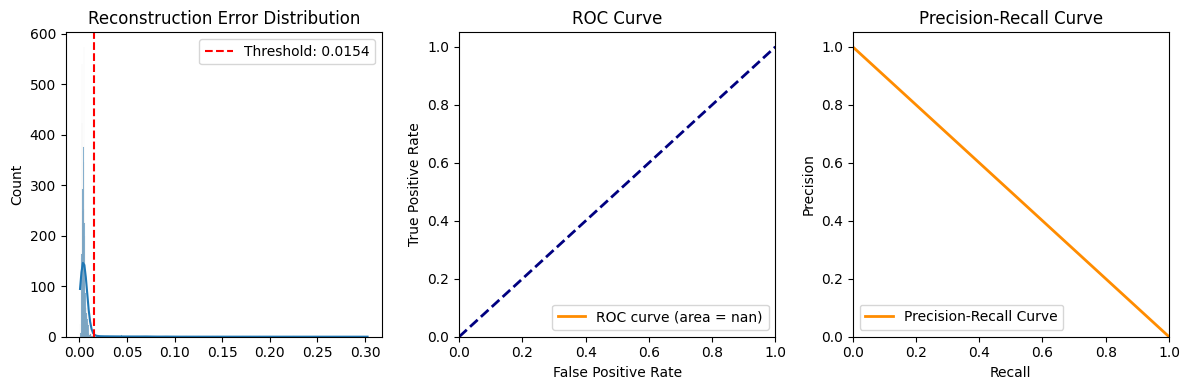

Model saved to ./enhanced_autoencoder_model_best_20241212_031320.pth
Scaler saved to ./scaler_20241212_031320.joblib


In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import joblib
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Device selection
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Autoencoder architecture
class EnhancedAutoencoder(nn.Module):
    def __init__(self, input_dim):
        super(EnhancedAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.LeakyReLU(negative_slope=0.01)
        )
        self.decoder = nn.Sequential(
            nn.Linear(128, 256),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, 512),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Load and preprocess data (replace 'your_data.csv' with your file path)
try:
    data = pd.read_csv('/content/live_capture.csv')
except FileNotFoundError:
    print("Error: 'your_data.csv' not found. Please provide a valid file path.")
    exit()

# Handle missing values (example: fill with mean for numerical columns)
numerical_cols = ['SourcePort', 'DestinationPort', 'BytesSent', 'BytesReceived', 'PacketsSent', 'PacketsReceived', 'Duration']
for col in numerical_cols:
    data[col] = data[col].fillna(data[col].mean())

#One-hot encode categorical features
categorical_cols = ['SourceIP', 'DestinationIP', 'Protocol']
enc = OneHotEncoder(handle_unknown='ignore')
encoded_data = enc.fit_transform(data[categorical_cols]).toarray()
encoded_df = pd.DataFrame(encoded_data, columns=enc.get_feature_names_out(categorical_cols))
data = data.drop(columns=categorical_cols)
data = pd.concat([data, encoded_df], axis=1)

#Ensure that Malicious column is numeric. If not, convert it.
data['Malicious'] = data['Malicious'].str.lower()
data['Malicious'] = data['Malicious'].replace({'benign': 0, 'malicious': 1})
data['Malicious'] = pd.to_numeric(data['Malicious'], errors='coerce')
data = data.dropna(subset=['Malicious'])

# Separate features and labels
features = data.drop(columns=['Malicious'])
labels = data['Malicious'].astype(int)

# Scale numerical features
scaler = StandardScaler()
numerical_features = data[numerical_cols]
scaled_numerical_features = scaler.fit_transform(numerical_features)
scaled_numerical_df = pd.DataFrame(scaled_numerical_features, columns=numerical_cols)
features = features.drop(columns=numerical_cols)
features = pd.concat([features, scaled_numerical_df], axis=1)


# Split data (80% train, 10% val, 10% test)  using stratify for balanced classes
train_val_features, test_features, train_val_labels, test_labels = train_test_split(
    features, labels, test_size=0.1, random_state=42, stratify=labels
)
train_features, val_features, train_labels, val_labels = train_test_split(
    train_val_features, train_val_labels, test_size=0.111, random_state=42, stratify=train_val_labels
)

print(f"Train set shape: {train_features.shape}")
print(f"Validation set shape: {val_features.shape}")
print(f"Test set shape: {test_features.shape}")

# Convert to tensors
train_tensor = torch.tensor(train_features.values, dtype=torch.float32)
val_tensor = torch.tensor(val_features.values, dtype=torch.float32)
test_tensor = torch.tensor(test_features.values, dtype=torch.float32)

train_labels = train_labels.astype(np.float32).values
val_labels = val_labels.astype(np.float32).values
test_labels = test_labels.astype(np.float32).values

train_dataset = TensorDataset(train_tensor, torch.tensor(train_labels, dtype=torch.float32))
val_dataset = TensorDataset(val_tensor, torch.tensor(val_labels, dtype=torch.float32))
test_dataset = TensorDataset(test_tensor, torch.tensor(test_labels, dtype=torch.float32))

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss, and optimizer
input_dim = features.shape[1]
autoencoder = EnhancedAutoencoder(input_dim).to(device)
criterion = nn.MSELoss(reduction='none')
optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

# Training loop
epochs = 100 #Reduced for faster testing. Increase for better results
best_val_loss = float('inf')
patience = 10
epochs_without_improvement = 0

for epoch in range(epochs):
    autoencoder.train()
    epoch_loss = 0
    for batch_features, _ in train_loader:
        batch_features = batch_features.to(device)
        outputs = autoencoder(batch_features)
        loss = criterion(outputs, batch_features)
        # Calculate the mean of the loss across all elements to get a single scalar value
        loss = loss.mean()  # Calculate the mean loss for the batch
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.mean().item()
    avg_loss = epoch_loss / len(train_loader)
    scheduler.step()

    with torch.no_grad():
        val_loss = 0
        for batch_features, _ in val_loader:
            batch_features = batch_features.to(device)
            outputs = autoencoder(batch_features)
            loss = criterion(outputs, batch_features)
            val_loss += loss.mean().item()
        avg_val_loss = val_loss / len(val_loader)
        print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {avg_loss:.6f}, Val Loss: {avg_val_loss:.6f}')

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_without_improvement = 0
            best_model_state_dict = autoencoder.state_dict()
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping triggered after {epoch + 1} epochs.")
                break

#Threshold calculation (using training data) MUST BE BEFORE predicted_labels
#Threshold calculation (using training data) MUST BE BEFORE predicted_labels
reconstruction_errors_train = []
with torch.no_grad():
    for batch_features, _ in train_loader:
        batch_features = batch_features.to(device)
        outputs = autoencoder(batch_features)
        loss = criterion(outputs, batch_features)
        reconstruction_errors_train.extend([loss.mean().item()])

mean_loss_train = np.mean(reconstruction_errors_train)
std_loss_train = np.std(reconstruction_errors_train)
threshold = mean_loss_train + 3 * std_loss_train

#Testing and Visualization
autoencoder.load_state_dict(best_model_state_dict)
autoencoder.eval()
reconstruction_errors_test = []
true_labels_test = []

with torch.no_grad():
    for i, (batch_features, batch_labels) in enumerate(test_loader):
        batch_features = batch_features.to(device)
        outputs = autoencoder(batch_features)
        # Calculate loss for each sample in the batch
        loss = criterion(outputs, batch_features).mean(axis=1) # Calculate for each sample in batch
        reconstruction_errors_test.extend(loss.cpu().numpy())  # move to cpu before converting to numpy
        true_labels_test.extend(batch_labels.cpu().numpy())

print(f"Length of reconstruction_errors_test: {len(reconstruction_errors_test)}")
print(f"Length of true_labels_test: {len(true_labels_test)}")

predicted_labels = np.array(reconstruction_errors_test) > threshold

# Classify and evaluate
fpr, tpr, _ = roc_curve(true_labels_test, predicted_labels)
roc_auc = auc(fpr, tpr)
precision, recall, _ = precision_recall_curve(true_labels_test, predicted_labels)

# Create visualizations
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
sns.histplot(reconstruction_errors_test, kde=True)
plt.axvline(threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.4f}')
plt.title('Reconstruction Error Distribution')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

plt.subplot(1, 3, 3)
plt.plot(recall, precision, color='darkorange', lw=2, label='Precision-Recall Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()


# Save model and scaler
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_path = f'./enhanced_autoencoder_model_best_{timestamp}.pth'
scaler_path = f'./scaler_{timestamp}.joblib'

torch.save(autoencoder.state_dict(), model_path)
joblib.dump(scaler, scaler_path)

print(f"Model saved to {model_path}")
print(f"Scaler saved to {scaler_path}")

In [10]:
!pip install scapy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 29.6 MB/s eta 0:00:00


In [21]:
!ifconfig

/bin/bash: line 1: ifconfig: command not found


In [29]:
import torch
import torch.nn as nn
from scapy.all import sniff, IP, TCP, UDP
import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib  # For loading the scaler

# Define your autoencoder model class
# Adjust the input dimension based on the 7 features
input_dim = 7  # Update this to 7 instead of 603
model_path = 'ML/Model_Deployment/artifacts/12-12/enhanced_autoencoder_model_best_20241212_031320.pth'

# Modify the Autoencoder class accordingly
class EnhancedAutoencoder(nn.Module):
    def __init__(self, input_dim):
        super(EnhancedAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),  # Reduced layers due to fewer features
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(64, 32),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(32, 16),
            nn.LeakyReLU(negative_slope=0.01)
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(32, 64),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(64, input_dim),
            nn.Sigmoid()  # Output the reconstructed features
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Load the updated model (Note: This will need to be retrained if you're changing the architecture)

# Define the input dimension based on features
input_dim = 7  # SourcePort, DestinationPort, BytesSent, BytesReceived, PacketsSent, PacketsReceived, Duration

# Create a new model instance with the updated input dimension (7 features)
model = EnhancedAutoencoder(input_dim)

# Attempt to load pre-trained weights
try:
    pre_trained_model = torch.load(model_path)

    # Remove the keys that don't match the current model's architecture
    model_state_dict = model.state_dict()
    pre_trained_model = {k: v for k, v in pre_trained_model.items() if k in model_state_dict and v.size() == model_state_dict[k].size()}

    # Update the model with the compatible weights
    model_state_dict.update(pre_trained_model)
    model.load_state_dict(model_state_dict)

    # Ensure the model is in evaluation mode
    model.eval()
    print("Autoencoder model loaded and updated successfully.")

except FileNotFoundError:
    print(f"Model file not found at {model_path}. Please check the path.")
    exit(1)
except RuntimeError as e:
    print(f"Error loading the model: {e}")
    exit(1)

# Load your pre-trained StandardScaler
scaler_path = 'ML/Model_Deployment/artifacts/12-12/scaler_20241212_031320.joblib'
try:
    scaler = joblib.load(scaler_path)
    print("Scaler loaded successfully.")
except FileNotFoundError:
    print(f"Scaler file not found at {scaler_path}. Please check the path.")
    exit(1)

# Define a threshold for anomaly detection
threshold = 1.7  # Define a suitable threshold based on your training

# Function to preprocess packets and extract features
def preprocess_packet(packet):
    if IP in packet:
        # Extract features
        src_port = packet[TCP].sport if TCP in packet else (packet[UDP].sport if UDP in packet else 0)
        dst_port = packet[TCP].dport if TCP in packet else (packet[UDP].dport if UDP in packet else 0)
        bytes_sent = len(packet)
        bytes_received = 0  # Placeholder
        packets_sent = 1  # Placeholder
        packets_received = 0  # Placeholder
        duration = 0  # Placeholder

        # Return the feature vector with exactly 7 features
        features = np.array([src_port, dst_port, bytes_sent, bytes_received, packets_sent, packets_received, duration])
        return features
    return None

# Function to preprocess and predict anomalies
def preprocess_and_predict(features):
    # Ensure the feature vector has the correct dimensions (7)
    features_reshaped = np.array(features).reshape(1, -1)  # Shape (1, 7)

    # Scale the features (using the scaler trained on 7 features)
    try:
        scaled_features = scaler.transform(features_reshaped)
    except ValueError as e:
        print(f"Error during scaling: {e}")
        return

    # Convert to PyTorch tensor
    features_tensor = torch.tensor(scaled_features, dtype=torch.float32)

    # Feed to the model
    with torch.no_grad():
        reconstructed = model(features_tensor)

    # Calculate reconstruction error (MSE)
    mse_loss = nn.MSELoss()
    loss = mse_loss(reconstructed, features_tensor).item()
    limit=1.7

    # If the loss exceeds a certain threshold, it might be an anomaly
    if loss > threshold:
        print(f"Anomaly detected! Reconstruction loss: {loss:.6f}")
    else:
        print(f"Regular traffic. Reconstruction loss: {loss:.6f}")

# Function to process each captured packet
def process_packet(packet):
    features = preprocess_packet(packet)
    if features is not None:
        preprocess_and_predict(features)

# Start capturing packets on the desired interface
selected_interface = "Wi-Fi"  # Change this to your interface name
print("Starting packet capture...")
sniff(filter="ip", iface=selected_interface, prn=process_packet, store=0)


Starting packet capture...


ValueError: Interface 'Wi-Fi' not found !

Using device: cuda


<ipython-input-3-97ef80cb18a3>:75: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Malicious'] = data['Malicious'].replace({'benign': 0, 'malicious': 1})


Train set shape: (44548, 603)
Validation set shape: (5563, 603)
Test set shape: (5568, 603)
Epoch 1/100, Train Loss: 0.176435, Val Loss: 0.075151
Epoch 2/100, Train Loss: 0.053852, Val Loss: 0.044282
Epoch 3/100, Train Loss: 0.038757, Val Loss: 0.034892
Epoch 4/100, Train Loss: 0.033659, Val Loss: 0.033413
Epoch 5/100, Train Loss: 0.031928, Val Loss: 0.030613
Epoch 6/100, Train Loss: 0.030742, Val Loss: 0.029883
Epoch 7/100, Train Loss: 0.029753, Val Loss: 0.027641
Epoch 8/100, Train Loss: 0.028964, Val Loss: 0.027914
Epoch 9/100, Train Loss: 0.028301, Val Loss: 0.027689
Epoch 10/100, Train Loss: 0.028710, Val Loss: 0.027691
Epoch 11/100, Train Loss: 0.028446, Val Loss: 0.027161
Epoch 12/100, Train Loss: 0.027917, Val Loss: 0.028656
Epoch 13/100, Train Loss: 0.027544, Val Loss: 0.026713
Epoch 14/100, Train Loss: 0.027003, Val Loss: 0.025881
Epoch 15/100, Train Loss: 0.026867, Val Loss: 0.025993
Epoch 16/100, Train Loss: 0.026827, Val Loss: 0.026088
Epoch 17/100, Train Loss: 0.026412, V

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


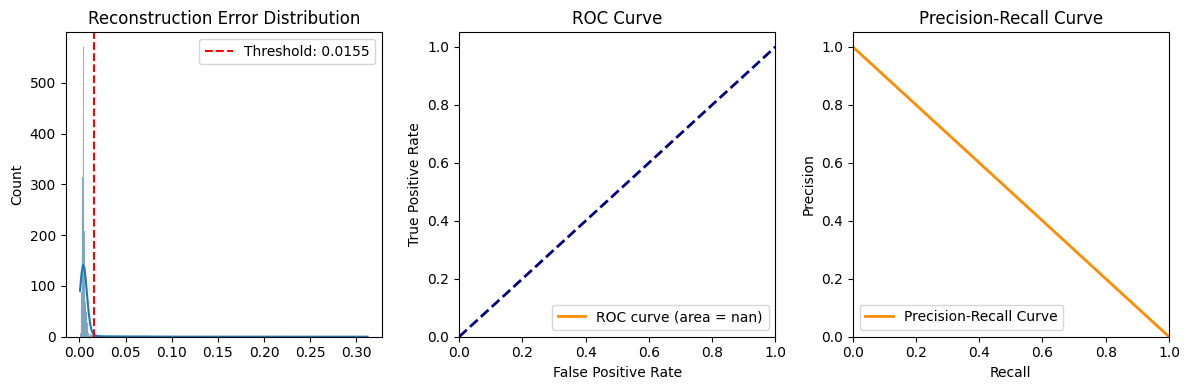

Model saved to ./enhanced_autoencoder_model_best_20241212_043858.pth
Scaler saved to ./scaler_20241212_043858.joblib


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import joblib
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Device selection
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Autoencoder architecture
class EnhancedAutoencoder(nn.Module):
    def __init__(self, input_dim):
        super(EnhancedAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.LeakyReLU(negative_slope=0.01)
        )
        self.decoder = nn.Sequential(
            nn.Linear(128, 256),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, 512),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Load and preprocess data (replace 'your_data.csv' with your file path)
try:
    data = pd.read_csv('/content/live_capture.csv')
except FileNotFoundError:
    print("Error: 'your_data.csv' not found. Please provide a valid file path.")
    exit()

# Handle missing values (example: fill with mean for numerical columns)
numerical_cols = ['SourcePort', 'DestinationPort', 'BytesSent', 'BytesReceived', 'PacketsSent', 'PacketsReceived', 'Duration']
for col in numerical_cols:
    data[col] = data[col].fillna(data[col].mean())

# One-hot encode categorical features
categorical_cols = ['SourceIP', 'DestinationIP', 'Protocol']
enc = OneHotEncoder(handle_unknown='ignore')
encoded_data = enc.fit_transform(data[categorical_cols]).toarray()
encoded_df = pd.DataFrame(encoded_data, columns=enc.get_feature_names_out(categorical_cols))
data = data.drop(columns=categorical_cols)
data = pd.concat([data, encoded_df], axis=1)

# Ensure that Malicious column is numeric. If not, convert it.
data['Malicious'] = data['Malicious'].str.lower()
data['Malicious'] = data['Malicious'].replace({'benign': 0, 'malicious': 1})
data['Malicious'] = pd.to_numeric(data['Malicious'], errors='coerce')
data = data.dropna(subset=['Malicious'])

# Separate features and labels
features = data.drop(columns=['Malicious'])
labels = data['Malicious'].astype(int)

# Scale numerical features
scaler = StandardScaler()
numerical_features = data[numerical_cols]
scaled_numerical_features = scaler.fit_transform(numerical_features)
scaled_numerical_df = pd.DataFrame(scaled_numerical_features, columns=numerical_cols)
features = features.drop(columns=numerical_cols)
features = pd.concat([features, scaled_numerical_df], axis=1)

# Split data (80% train, 10% val, 10% test) using stratify for balanced classes
train_val_features, test_features, train_val_labels, test_labels = train_test_split(
    features, labels, test_size=0.1, random_state=42, stratify=labels
)
train_features, val_features, train_labels, val_labels = train_test_split(
    train_val_features, train_val_labels, test_size=0.111, random_state=42, stratify=train_val_labels
)

print(f"Train set shape: {train_features.shape}")
print(f"Validation set shape: {val_features.shape}")
print(f"Test set shape: {test_features.shape}")

# Convert to tensors
train_tensor = torch.tensor(train_features.values, dtype=torch.float32)
val_tensor = torch.tensor(val_features.values, dtype=torch.float32)
test_tensor = torch.tensor(test_features.values, dtype=torch.float32)

train_labels = train_labels.astype(np.float32).values
val_labels = val_labels.astype(np.float32).values
test_labels = test_labels.astype(np.float32).values

train_dataset = TensorDataset(train_tensor, torch.tensor(train_labels, dtype=torch.float32))
val_dataset = TensorDataset(val_tensor, torch.tensor(val_labels, dtype=torch.float32))
test_dataset = TensorDataset(test_tensor, torch.tensor(test_labels, dtype=torch.float32))

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss, and optimizer
input_dim = features.shape[1]
autoencoder = EnhancedAutoencoder(input_dim).to(device)
criterion = nn.MSELoss(reduction='none')
optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

# Training loop
epochs = 100 # Reduced for faster testing. Increase for better results
best_val_loss = float('inf')
patience = 10
epochs_without_improvement = 0

for epoch in range(epochs):
    autoencoder.train()
    epoch_loss = 0
    for batch_features, _ in train_loader:
        batch_features = batch_features.to(device)
        outputs = autoencoder(batch_features)
        loss = criterion(outputs, batch_features)
        # Calculate the mean of the loss across all elements to get a single scalar value
        loss = loss.mean()  # Calculate the mean loss for the batch
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.mean().item()
    avg_loss = epoch_loss / len(train_loader)
    scheduler.step()

    with torch.no_grad():
        val_loss = 0
        for batch_features, _ in val_loader:
            batch_features = batch_features.to(device)
            outputs = autoencoder(batch_features)
            loss = criterion(outputs, batch_features)
            val_loss += loss.mean().item()
        avg_val_loss = val_loss / len(val_loader)
        print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {avg_loss:.6f}, Val Loss: {avg_val_loss:.6f}')

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_without_improvement = 0
            best_model_state_dict = autoencoder.state_dict()
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping triggered after {epoch + 1} epochs.")
                break

# Calculate reconstruction errors for training data (after model has been trained)
reconstruction_errors_train = []
with torch.no_grad():
    for batch_features, _ in train_loader:
        batch_features = batch_features.to(device)
        outputs = autoencoder(batch_features)
        loss = criterion(outputs, batch_features)
        reconstruction_errors_train.extend([loss.mean().item()])

# Calculate mean and standard deviation of the training reconstruction errors
mean_loss_train = np.mean(reconstruction_errors_train)
std_loss_train = np.std(reconstruction_errors_train)

# Define the threshold for anomaly detection
threshold = mean_loss_train + 3 * std_loss_train  # This is commonly used for anomaly detection

print(f"Threshold for reconstruction error: {threshold:.4f}")

# Evaluate the model on the test set using the computed threshold
autoencoder.load_state_dict(best_model_state_dict)
autoencoder.eval()
reconstruction_errors_test = []
true_labels_test = []

with torch.no_grad():
    for i, (batch_features, batch_labels) in enumerate(test_loader):
        batch_features = batch_features.to(device)
        outputs = autoencoder(batch_features)
        # Calculate loss for each sample in the batch
        loss = criterion(outputs, batch_features).mean(axis=1) # Calculate for each sample in batch
        reconstruction_errors_test.extend(loss.cpu().numpy())  # move to cpu before converting to numpy
        true_labels_test.extend(batch_labels.cpu().numpy())

# Convert reconstruction errors to binary labels based on the threshold
predicted_labels = np.array(reconstruction_errors_test) > threshold

# Evaluate the model's performance
fpr, tpr, _ = roc_curve(true_labels_test, predicted_labels)
roc_auc = auc(fpr, tpr)
precision, recall, _ = precision_recall_curve(true_labels_test, predicted_labels)

# Create visualizations
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
sns.histplot(reconstruction_errors_test, kde=True)
plt.axvline(threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.4f}')
plt.title('Reconstruction Error Distribution')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

plt.subplot(1, 3, 3)
plt.plot(recall, precision, color='darkorange', lw=2, label='Precision-Recall Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

# Save model and scaler
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_path = f'./enhanced_autoencoder_model_best_{timestamp}.pth'
scaler_path = f'./scaler_{timestamp}.joblib'

torch.save(autoencoder.state_dict(), model_path)
joblib.dump(scaler, scaler_path)

print(f"Model saved to {model_path}")
print(f"Scaler saved to {scaler_path}")
